In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
from configparser import ConfigParser
from keras.metrics import Precision,Recall,AUC,KLDivergence,Poisson,MeanAbsoluteError,F1Score,FBetaScore,CategoricalAccuracy
from keras.callbacks import EarlyStopping
import scipy
from ModelSelector import  ModelSelector
import keras_cv
import keras
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras.callbacks import Callback
from keras_cv.models import ImageClassifier
from keras_cv.layers import RandAugment
from keras.models import Sequential
from LoadData import LoadData


Cargamos las configuraciones necesarias

In [5]:
configfile_name = "config.ini" 
config= ConfigParser()
config.read(configfile_name)
image_size = int(config.get("dataset","image_size"))
color_mode=config.get("dataset","color_mode")
batch_size = int(config.get("dataset","batch_size"))
base_dir=config.get("dataset","base_dir")
dest_dir=config.get("dataset","dest_dir")

Cargamos el dataset

In [7]:
LoadData=LoadData(image_size,color_mode,batch_size)

TypeError: 'LoadData' object is not callable

In [8]:
train_ds=LoadData.load_train_data(dest_dir)
test_ds=LoadData.load_test_data(dest_dir)
val_ds=LoadData.load_validation_data(dest_dir)


Found 1176 files belonging to 3 classes.
Found 394 files belonging to 3 classes.
Found 392 files belonging to 3 classes.


In [10]:
def mostrar_imagenes(dataset):
    """
    Muestra las primeras 9 imágenes de un lote del dataset junto con sus etiquetas.
    Las etiquetas se infieren automáticamente desde el atributo `class_names` del dataset.

    Args:
        dataset (tf.data.Dataset): Dataset cargado con image_dataset_from_directory.
    """
    try:
        # Obtener nombres de las clases directamente del dataset
        class_names = dataset.class_names
    except AttributeError:
        raise ValueError("El dataset proporcionado no contiene información de `class_names`.")

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Tomar un lote del dataset
        for i in range(9):  # Mostrar las primeras 9 imágenes del lote
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            # Convertir etiquetas categóricas en nombres de clases
            plt.title(class_names[labels[i].numpy().argmax()])
            plt.axis("off")
    plt.show()


Mostramos las diferentes clases del dataset

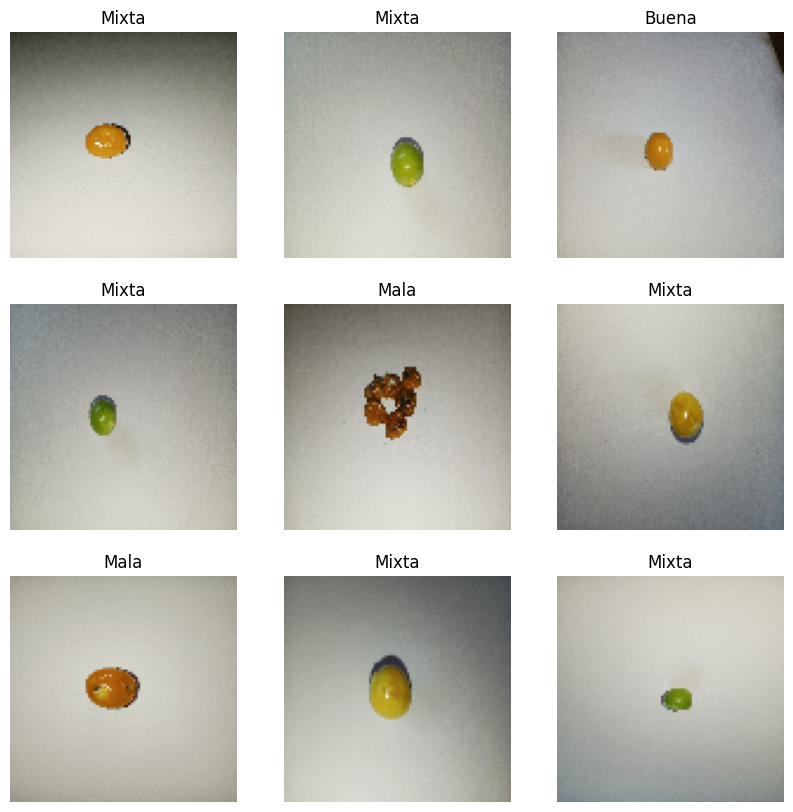

In [11]:
mostrar_imagenes(train_ds)

Seleccionamos algun modelo preentrenado (terminacion_pretrained) o su arquitectura de capas de nuestra clase Model Selector.
- resnet50
- resnet50_pretained
- resnet152
- cspdarknet
- cspdarknet_pretained
- densenet169
- densenet169_pretrained
- efficientnet
- efficientnet_V1
- efficientnet_V2_pretained
- efficientnet_V2
- mobilenet_V3_pretrained
- mobilenet_V3
- yolo_v8
- yolo_v8_pretained

In [13]:
backbone = ModelSelector(image_size=image_size, color_space=color_mode, model='efficientnet_V2_pretained').load_model()


In [14]:
model = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=3,
    activation="softmax",
    pooling="avg",
)

In [15]:
def build_model(hp, X_train):
    # Crear el objeto RandAugment con hiperparámetros ajustables
    augmenter = RandAugment(
        value_range=(0, 255),
        augmentations_per_image=hp.Int('augmentations_per_image', min_value=2, max_value=5, step=1, default=3),
        magnitude=hp.Float('magnitude', min_value=0.1, max_value=1.0, step=0.1, default=0.5),
        magnitude_stddev=hp.Float('magnitude_stddev', min_value=0.05, max_value=0.3, step=0.05, default=0.15),
        rate=hp.Float('rate', min_value=0.5, max_value=1.0, step=0.1, default=0.9),
        geometric=True
    )

    # Crear el modelo base
    model = ImageClassifier(
        backbone=backbone,
        num_classes=3,
        activation="softmax",
        pooling="avg"
    )

    # Aplicar las transformaciones de RandAugment a los datos de entrenamiento y validación
    X_train_aug = X_train.map(lambda x, y: (augmenter(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Compilar el modelo final
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model, X_train_aug

# Crear el tuner de Keras
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, X_train=train_ds)[0],  # Devuelve solo el modelo
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='rand_augment_tuning_mobile'
)

# Ejecutar la búsqueda de hiperparámetros
tuner.search(x=train_ds, validation_data=val_ds, epochs=10)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Mejores hiperparámetros: {best_hps.values}')

# Crear el modelo final con los mejores hiperparámetros


Trial 1 Complete [00h 32m 41s]
val_loss: 0.21478772163391113

Best val_loss So Far: 0.21478772163391113
Total elapsed time: 00h 32m 41s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
2                 |5                 |augmentations_per_image
0.3               |0.7               |magnitude
0.05              |0.05              |magnitude_stddev
0.9               |0.9               |rate

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step - accuracy: 0.9380 - loss: 0.2051 - val_accuracy: 0.8699 - val_loss: 0.4068
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.9748 - loss: 0.0695 - val_accuracy: 0.9184 - val_loss: 0.2539
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9811 - loss: 0.0872 - val_accuracy: 0.8903 - val_loss: 0.3680
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.9947 - loss: 0.0260 - val_accuracy: 0.9082 - val_loss: 0.6654
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.96

KeyboardInterrupt: 

In [9]:
final_model, X_train_aug, X_val_aug = build_model(best_hps, X_train=train_ds, X_val=val_ds)

In [10]:
%load_ext tensorboard

In [12]:
log_dir="./ckpt_mobile_rand_augment"
checkpoint_dir=log_dir+'/ckpt'
checkpoint_filepath = checkpoint_dir+'/checkpoint_{epoch}.keras'

In [13]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,verbose=1,    save_best_only=True,
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
csv_logger = tf.keras.callbacks.CSVLogger('training_log_algo_mobile_random.csv', append=True)


In [14]:
checkpoint_files = os.listdir(checkpoint_dir)
checkpoint_files = [file for file in checkpoint_files if file.startswith('checkpoint_')]

In [15]:
print(checkpoint_files)

[]


In [16]:
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[  Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        MeanAbsoluteError(name='mae'),
        CategoricalAccuracy(name="categorical_accuracy", dtype=None),
         
         Poisson(name="poisson", dtype=None),
         ]
       

)


In [17]:
if checkpoint_files:
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1]
    last_epoch = int(latest_checkpoint.split('_')[1].split('.')[0])
    final_model = tf.keras.models.load_model(os.path.join(checkpoint_dir, latest_checkpoint))
else:
    print("No hay checkpoints.")
    last_epoch = 0  # Comienza desde la primera época

final_model.fit(
    X_train_aug,
    epochs=100,
    validation_data=val_ds,
    initial_epoch=last_epoch,
    callbacks=[ model_checkpoint_callback, early_stopping, reduce_lr, csv_logger,tensorboard_callback],
    

)

No hay checkpoints.
Epoch 1/100


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - auc: 0.3688 - categorical_accuracy: 0.3210 - loss: 1.4254 - mae: 0.4814 - poisson: 0.8085 - precision: 0.1125 - recall: 0.0377
Epoch 1: val_loss improved from inf to 4.58003, saving model to ./ckpt_mobile_rand_augment/ckpt/checkpoint_1.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - auc: 0.3685 - categorical_accuracy: 0.3212 - loss: 1.4229 - mae: 0.4812 - poisson: 0.8076 - precision: 0.1137 - recall: 0.0385 - val_auc: 0.6604 - val_categorical_accuracy: 0.5000 - val_loss: 4.5800 - val_mae: 0.3400 - val_poisson: 1.5976 - val_precision: 0.5056 - val_recall: 0.5000 - learning_rate: 1.0000e-05
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - auc: 0.4011 - categorical_accuracy: 0.3213 - loss: 1.3105 - mae: 0.4684 - poisson: 0.7702 - precision: 0.1277 - recall: 0.0408
Epoch 2: val_loss improved from 4.58003 to 4.41143, saving model to ./ckpt_mobile_rand_augment/ckpt/checkpoint_2.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - auc: 0.4035 - catego

In [16]:
%tensorboard --logdir ckpt_resnet/

Reusing TensorBoard on port 6012 (pid 6648), started 2 days, 20:54:36 ago. (Use '!kill 6648' to kill it.)

In [18]:
final_model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - auc: 0.7183 - categorical_accuracy: 0.5668 - loss: 6.0555 - mae: 0.2871 - poisson: 1.6476 - precision: 0.5668 - recall: 0.5668


[5.930760860443115,
 0.5555555820465088,
 0.5555555820465088,
 0.7141358852386475,
 0.2925652265548706,
 0.5555555820465088,
 1.66157865524292]

In [19]:
y_pred=final_model.predict(test_ds)
y_pred_label=np.argmax(y_pred, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


In [20]:
import numpy as np
import tensorflow as tf

# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    preds = final_model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))  # Obtener la clase predicha
    true_labels.extend(np.argmax(labels, axis=1))  # Obtener la clase verdadera

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


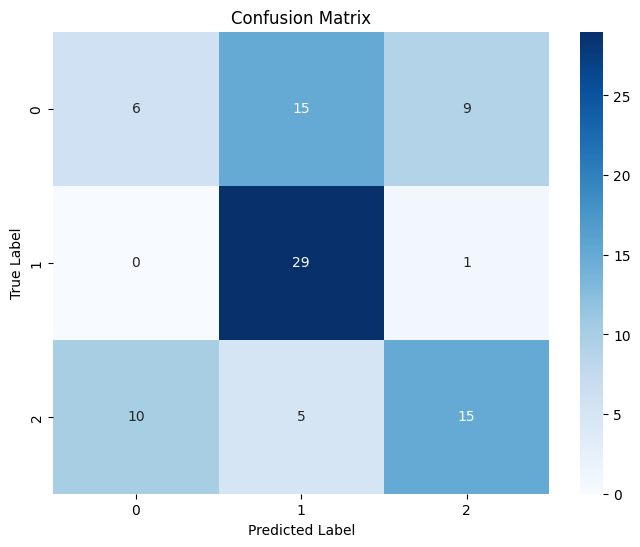

In [21]:
# Crear la matriz de confusión
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convertir a numpy para facilitar la visualización
cm = cm.numpy()

# Visualizar la matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
final_model.save("modelo_fin.keras")

In [ ]:
model = keras.models.load_model("modelo_mobile.keras")